# **Web Scraping with BeautifulSoup4**


<a target="_blank" href="https://colab.research.google.com/github/chenwh0/Natural-Language-Processing-work/blob/main/module1/WebscrapingWithBeautifulSoup4.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Installs & Imports

In [ ]:
!pip install beautifulsoup4 requests lxml html5lib nltk spacy -q

In [ ]:
# Webscrapping Libraries
from pprint import pprint # Pretty-prints data structures
from bs4 import BeautifulSoup # Parses HTML
from urllib.request import urlopen # Opens URLs
from urllib.parse import urljoin, urlparse # More sophisticated link extraction by category

# Parsing/cleaning data Libraries
import json
import pandas
import numpy
import html

# Data visualization Libraries
import matplotlib.pyplot as plt

# Error-handling Libraries
import time
import random
from requests.exceptions import RequestException
import lxml

# user-agent headers Libraries
import requests

# Extract from parsed html content

In [ ]:
url_to_scrape = "https://muidsi.missouri.edu/academic-programs/m-s-data-science-and-analytics-program/masters/curriculum/"
html_content_in_url = urlopen(url_to_scrape).read()
parsed_html_content = BeautifulSoup(html_content_in_url, "html.parser")
pprint(parsed_html_content.prettify())

print("\n\nPrint 1st 2000 chars...")
pprint(parsed_html_content.prettify()[:2000])

## *Extract by tag*

In [ ]:
print("\n\nPrint title...")
pprint(parsed_html_content.title) # confirms that correct page is being scraped.

print("\n\nPrint all headers...")
headings = parsed_html_content.find_all(["h1", "h2", "h3", "h4",  "h5", "h6"]) # confirms that correct page is being scraped.
hierarchy = []
for header in headings:
    level = int(header.name[1]) # Get # from h1, h2, h3...
    text = header.get_text(strip=True)
    indent_amount = '  ' * (level - 1)
    hierarchy.append(
        {
            "level": level,
            "text": text,
            "indent": '  ' * (level - 1)
        }
    )
    print(f"{indent_amount}{text}")
print(hierarchy)


print("\n\nPrint all links...")
all_hrefs = [link["href"] for link in parsed_html_content.find_all('a', href=True)]
print(all_hrefs)
# protocol URLs = Special protocols like mailto: or tel:
# fragment URLs = links to webpage's sections like #section1.


base_url = "https://muidsi.missouri.edu/"
internal_links = []
external_links = []
for href in all_hrefs:
    full_url = urljoin(base_url, href)
    if urlparse(full_url).netloc == urlparse(base_url).netloc: # .netloc gets part of URL right after http:// (identifies the network host and optional login information and port number)
        internal_links.append(full_url)
    else:
        external_links.append(full_url)

print("\n\nPrint internal links...")
pprint(internal_links)

print("\n\nPrint external links...")
pprint(external_links)



Print title...
<title>Curriculum – MU Institute for Data Science and Informatics</title>


Print all headers...
University of Missouri
Curriculum
  Core Courses
  Advanced Courses
  Emphasis Area Courses
  Sample Course Paths
  Core Courses
    The core course material continually builds upon the Data Science lifecycle theme.
  Advanced Courses
    Case studies and capstone allow students to specialize in one or a couple of particular domains.
  Emphasis Area Courses
    Emphasis courses represent the final stage in the further refinement of learning with domain-specific data and challenges.
      BioHealth Analytics
      Geospatial Analytics
      Human-Centered Science Design
      Data Journalism/Strategic Communication
      High-Performance Computing
  Apply Now
    Sample Course Path
  More Information
  Contact us
    MU Institute for Data Science and Informatics
[{'level': 1, 'text': 'University of Missouri', 'indent': ''}, {'level': 1, 'text': 'Curriculum', 'indent': ''}, {

## *Extract text*

In [ ]:
def clean_text_extract(soup_obj):
    for script in soup_obj(["script", "style"]):
        script.decompose() # Remove script & style elements
    text = parsed_html_content.get_text() # Extract all visible text
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = ' '.join(chunk for chunk in chunks if chunk)
    return text
clean_text = clean_text_extract(parsed_html_content)
print(clean_text[:500])

Curriculum – MU Institute for Data Science and Informatics Skip to navigation Skip to content MU LogoUniversity of Missouri Searchsearch MU Institute for Data Science and Informatics menu About expand_more A Message from the Director Cutting Edge Research Mission Academic Programs expand_more Informatics PhD M.S. Data Science and Analytics Data Science Graduate Certificates News Events Research expand_more Data Driven Discovery Initiatives Grants Labs Graduate Student Organization expand_more Mi


## *Extract tabular data*

In [ ]:
def extract_tabular_data(soup_obj):
    all_tables = []
    for i, table in enumerate(soup_obj.find_all("table")):
        table_data = []
        rows = table.find_all("tr")
        for row in rows:
            cells = row.find_all("th", "td")
            row_data = [cell.get_text(strip=True) for cell in cells]
            if row_data: # Only append non-empty rows
                table_data.append(row_data)
        if table_data:
            all_tables.append({
                "table_number": i,
                "table_data": table_data,
                "rows": len(table_data),
                "columns": len(table_data[0]) if table_data else 0
            })
    return all_tables

all_table_data = extract_tabular_data(parsed_html_content)
all_table_data

[]

# Industry web-scraping practices

1. Always check website.com/robots.txt before scraping
2. Add delays between requests to not overwhelm servers
3. Comply with terms of use, intellectual property, and fair use guidelines

## *Handle errors*

In [ ]:
def add_scraping_delays(url, max_retries=3):
    for attempt in range(max_retries):
        try:
            time.sleep(random.uniform(1,3))
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            return BeautifulSoup(response.content, "lxml")
        except:
            if attempt == max_retries - 1:
                raise e
            print(f"Attempt {attempt+1} failed. Retrying...")
            time.sleep(2**attempt) # Exponential backoff

## *User-agent headers*

`User-Agent` value includes details about the operating system, browser type, rendering engine, and browser version.
* In web-scraping, this mimicks a real browser and avoids triggering websites to think you're a robot/attacker

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
url = "https://muidsi.missouri.edu/"
response = requests.get(url, headers=headers)
print(response.status_code)  # Check if the request was successful (within 2xx range)

200



## Introduction to BeautifulSoup4

**Purpose:**
BeautifulSoup4 (BS4) is a powerful Python library designed for parsing HTML and XML documents with ease. It's particularly valuable for web scraping tasks, text extraction, and data mining from websites. BeautifulSoup excels at handling messy or poorly formatted HTML by converting raw HTML into a structured parse tree, making it intuitive to navigate and extract the specific data you need.

**Why BeautifulSoup?**
- **Intuitive syntax**: Uses familiar Python methods to navigate HTML structures
- **Robust parsing**: Handles malformed HTML gracefully
- **Flexible selectors**: Supports CSS selectors, tag searching, and attribute-based filtering
- **Integration-friendly**: Works seamlessly with other Python data science libraries

## Installation and Setup

**Purpose:**
This section guides you through installing BeautifulSoup4 and its companion libraries that enhance web scraping capabilities and enable advanced data processing workflows.

```python
# Install BeautifulSoup4 and related libraries
pip install beautifulsoup4 requests lxml html5lib nltk spacy
```

**Library Overview:**

- **`beautifulsoup4`**: The core library for parsing HTML/XML documents
- **`requests`**: Modern HTTP library for downloading web pages with robust error handling
- **`lxml`**: High-performance XML and HTML parser, ideal for processing large documents
- **`html5lib`**: Standards-compliant parser that handles malformed HTML and ensures valid HTML5 output
- **`nltk`, `spacy`**: Natural Language Processing libraries for advanced text analysis after scraping

**Pro Tip:** While `requests` is recommended for production use, this tutorial uses `urllib` (built into Python) to minimize dependencies.

## Choosing the Right Parser

**Purpose:**
Understanding parser differences helps you select the optimal tool for your specific scraping needs, balancing speed, accuracy, and compatibility requirements.

**Parser Comparison:**

- **`html.parser`**: Python's built-in parser
  - *Pros*: No additional installation required, reliable
  - *Cons*: Slower than alternatives, less forgiving of malformed HTML
  - *Best for*: Simple scraping tasks, learning environments

- **`lxml`**: Third-party XML/HTML parser
  - *Pros*: Fastest option, feature-rich, excellent for large documents
  - *Cons*: External dependency, may be overkill for simple tasks
  - *Best for*: High-volume scraping, performance-critical applications

- **`html5lib`**: Standards-compliant HTML5 parser
  - *Pros*: Most accurate parsing, handles broken HTML gracefully
  - *Cons*: Slowest option due to thoroughness
  - *Best for*: Parsing heavily malformed HTML, ensuring standards compliance

**Selection Guide:** Start with `'lxml'` for speed, fall back to `'html5lib'` if you encounter parsing errors with malformed HTML.

## Setting Up Your First Web Scraping Project
**Purpose:**
This foundational example demonstrates the complete workflow: importing libraries, fetching web content, and creating a BeautifulSoup object ready for data extraction.

# Assignment: Intermediate Web Scraping with BeautifulSoup and Data Analysis (10 points)


**Background:**  
You have practiced basic web scraping using BeautifulSoup to extract static content from a website. In this assignment, you will go a step further by scraping a more structured dataset (such as a table or a list of items), cleaning the data, and performing simple analysis or visualization.

**Important note:**
You are allowed to use any generative AI tool of your preference, as long as you are explicit about how and when/where you have used it to obtain your answers. You will be graded on the quality of your answers and your *understanding* of the concepts. *NOT on the quality of your code*. For example, you can use AI to come up with code solutions for each task, but a detailed explanation of your choices must be given. This includes but is not limited to: (i) what the code does, (ii) output samples if available, and (iii) your analysis. If your code is generated with AI, you should mention it and the name of the AI model used.

## **Instructions and Point Breakdown**

**1. Choose a Website and Identify Structured Data (2 points)**
- Select a website with a clearly structured dataset (e.g., a table of course listings, a list of books, or a set of product reviews). Explain your choice (i.e., Was the subject of the website relevant to you? Was the structure of the HTML easier to deal with? etc.)
- Briefly describe the dataset you plan to scrape (structure, fields, and why you chose it).

**2. Scrape Data Using BeautifulSoup (3 points)**
- Write Python code to:
  - Fetch the webpage using `requests` (1 point)
  - Parse the HTML and extract at least **three fields** per item (e.g., title, price, rating). Explain your choice of columns. (2 points)

**3. Clean and Organize the Data (2 points)**
- Convert your parsed data into a pandas DataFrame.
- Perform at least **2 cleaning operations**:
  - Convert numeric columns (e.g., remove commas/units)
  - Standardize text formats (e.g, convert to lower case)
  - Handle missing values (e.g, fill with NaN)
  - Anything else that might be needed for your particular data
- Give a brief explanation of the cleaning operations performed

**4. Simple Data Analysis or Visualization (2 points)**
- Perform **one** simple analysis or visualization, such as:
  - Sort and display top items in a category
  - Calculate averages/sums of numeric columns
  - Create a bar chart or pie chart to compare categories using matplotlib or seaborn
- Give a brief description of the plot and/or summarized data.

**5. Reflection and Extension (1 point)**
- In a short paragraph, answer:
  - What challenges did you face compared to the basic example?
  - Are there other Python packages (like Scrapy or Selenium) that might help if the site was more complex?
  - Suggest one AI prompt you could use with Copilot to help automate or improve your code (e.g., “Generate code to handle pagination in BeautifulSoup”).

## **Submission**
- Submit your Jupyter notebook with:
  - Code (well-commented) and descriptions when needed
  - Output (data and visualization)
  - Reflection paragraph

**Grading Rubric:**
| Section                        | Points |
|--------------------------------|--------|
| Website choice & description   |   2    |
| Data scraping (code & fields)  |   3    |
| Data cleaning & organization   |   2    |
| Analysis or visualization      |   2    |
| Reflection & extension         |   1    |
| **Total**                      | **10** |

This assignment builds on your notes by requiring structured data extraction, basic cleaning, and a simple analysis or visualization, while encouraging you to think about next steps and tools for more advanced scraping tasks.

## 1. Choose a Website and Identify Structured Data (2 points)
* Originally, I wanted to work with [Goodreads Top 100: Standalones Edition Highest Rated...](https://www.goodreads.com/list/show/191616.Goodreads_Top_100_Standalones_Edition_Highest_Rated_Standalones_on_Goodreads_with_at_least_10_000_Ratings) but I didn't like the way the various book titles, authors, ratings, etc. were ALL nestled inside classes with very specific names so I decided to go with [100 Best Animated Movies of All Time
](https://www.gamedesigning.org/best-animated-movies/) because animated movies are also something I've always enjoyed learning and creating myself. The website is structured very basically (such as using a few `<h3>` or `<li>` tags) and less nestling when it comes to structuring each movie data.
* I am planning to scrape the following from each animation movie on the website:
> * *title*
> * *Avg Rating*  
> * *Description*


# Sources used:
* Chatgpt (see AI-Usage-Appendix.md)
* https://www.w3schools.com/python/python_json.asp
* https://www.geeksforgeeks.org/python/python-convert-html-characters-to-strings/
* https://www.geeksforgeeks.org/python/create-a-pandas-dataframe-from-list-of-dicts/
* https://www.geeksforgeeks.org/python/apply-a-function-to-single-or-selected-columns-or-rows-in-pandas-dataframe/
* https://www.geeksforgeeks.org/python/how-to-plot-value-counts-in-pandas/

## *2. Scrape Data Using BeautifulSoup (3 points)*

In [ ]:
URL = "https://www.imdb.com/list/ls507734871/"

In [ ]:
def get_parsed_html_content(url_to_scrape: str):
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url_to_scrape, headers=headers)
    print("status =", response.status_code)  # Check if the request was successful
    html_content_in_url = response.text
    return BeautifulSoup(html_content_in_url, "html.parser")

parsed_html_content = get_parsed_html_content(URL)
pprint(parsed_html_content.prettify()[:5000])

status = 200
<title>Best Animated Movies 2016-2024</title>



('<!DOCTYPE html>\n'
 '<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" '
 'xmlns:og="http://opengraphprotocol.org/schema/">\n'
 ' <head>\n'
 '  <meta charset="utf-8"/>\n'
 '  <meta content="width=device-width" name="viewport"/>\n'
 '  <script>\n'
 "   if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }\n"
 '  </script>\n'
 '  <script>\n'
 "   window.addEventListener('load', (event) => {\n"
 "        if (typeof window.csa !== 'undefined' && typeof window.csa === "
 "'function') {\n"
 "            var csaLatencyPlugin = window.csa('Content', {\n"
 '                element: {\n'
 "                    slotId: 'LoadTitle',\n"
 "                    type: 'service-call'\n"
 '                }\n'
 '            });\n'
 "            csaLatencyPlugin('mark', 'clickToBodyBegin', 1756648943826);\n"
 '        }\n'
 '    })\n'
 '  </script>\n'
 '  <title>\n'
 '   Best Animated Movies 2016-2024\n'
 '  </title>\

In [ ]:
json_data = parsed_html_content.find("script", type="application/ld+json").get_text() # Find <script> content of type "application/ld+json"
json_dict = json.loads(json_data) # Convert str to json data
animated_movies_desired_data = []

# Fetch each movies' title, rating, and description from json
for i in range(len(json_dict["itemListElement"])):
    animated_movie_data = json_dict["itemListElement"][i]["item"]
    animated_movie_desired_data = {"title": animated_movie_data["name"],
                                   "avg_rating": animated_movie_data["aggregateRating"]["ratingValue"],
                                   "description": animated_movie_data["description"]
                                }
    animated_movies_desired_data.append(animated_movie_desired_data)
    print(animated_movie_desired_data)

{'title': 'Moana', 'avg_rating': 7.6, 'description': 'In ancient Polynesia, when a terrible curse incurred by the demigod Maui reaches Moana&apos;s island, she answers the Ocean&apos;s call to seek out Maui to set things right.'}
{'title': 'Zootopia', 'avg_rating': 8, 'description': 'In a city of anthropomorphic animals, a rookie bunny cop and a cynical con artist fox must work together to uncover a conspiracy.'}
{'title': 'WolfWalkers', 'avg_rating': 8, 'description': 'A young apprentice hunter and her father journey to Ireland to help wipe out the last wolf pack. But everything changes when she befriends a free-spirited girl from a mysterious tribe rumored to transform into wolves by night.'}
{'title': 'Smallfoot', 'avg_rating': 6.6, 'description': 'When a Yeti discovers a human and his fellow Yeti refuse to believe humans exist, he embarks on an journey to find the creature that can put him back in his community&apos;s good graces.'}
{'title': 'Luck', 'avg_rating': 6.4, 'description

## *3. Clean and Organize the Data (2 points)*
**Cleaning operations**:
1. Convert all float ratings to int ratings by rounding via `round()`
2. Convert all special escape characters in the description text to readable characters.


In [ ]:
movies_dataframe = pandas.DataFrame.from_dict(animated_movies_desired_data)

In [ ]:
# Clearning operation #1: Rounding
print("Converting float ratings to int ratings via round() example:")
print("Original:", animated_movies_desired_data[0]["avg_rating"])
print("Rounded: ", round(animated_movies_desired_data[0]["avg_rating"])) # Rounded rating

movies_dataframe["avg_rating"] = numpy.round(movies_dataframe["avg_rating"])


# Cleaning operation #2: Reconvert special characters to readable format
print("\nConvert all special escape characters in the description text to readable characters example:")
print("Original:", animated_movies_desired_data[0]["description"])
print("Readable:", html.unescape(animated_movies_desired_data[0]["description"])) # Readable description text

movies_dataframe["description"] = movies_dataframe["description"].apply(html.unescape)

Converting float ratings to int ratings via round() ex:
Original: 7.6
Rounded:  8

Convert all special escape characters in the description text to readable characters ex:
Original: In ancient Polynesia, when a terrible curse incurred by the demigod Maui reaches Moana&apos;s island, she answers the Ocean&apos;s call to seek out Maui to set things right.
Readable: In ancient Polynesia, when a terrible curse incurred by the demigod Maui reaches Moana's island, she answers the Ocean's call to seek out Maui to set things right.


In [ ]:
movies_dataframe

,title,avg_rating,description
0,Moana,8.0,"In ancient Polynesia, when a terrible curse in..."
1,Zootopia,8.0,"In a city of anthropomorphic animals, a rookie..."
2,WolfWalkers,8.0,A young apprentice hunter and her father journ...
3,Smallfoot,7.0,When a Yeti discovers a human and his fellow Y...
4,Luck,6.0,The curtain is pulled back on the millennia-ol...
5,Finding Dory,7.0,Friendly but forgetful blue tang Dory begins a...
6,Nezha: Mo tong jiang shi,7.0,"Born with unique powers, a boy is recruited to..."
7,Wish Dragon,7.0,Determined teen Din is longing to reconnect wi...
8,Bai She: Yuan qi,7.0,A love story between a snake spirit and a snak...
9,Beavis and Butt-Head Do the Universe,7.0,"After a ""creative"" judge sentences them to spa..."


## *4. Simple Data Analysis or Visualization (2 points)*
The "Movie Rating Occurrences" bar chart below displays the number of occurrences given to each rounded rating score. Since the website already lists only the "Best Animated Movies 2016-2024", all of the rounded rating scores fall within the higher 6-8 range.

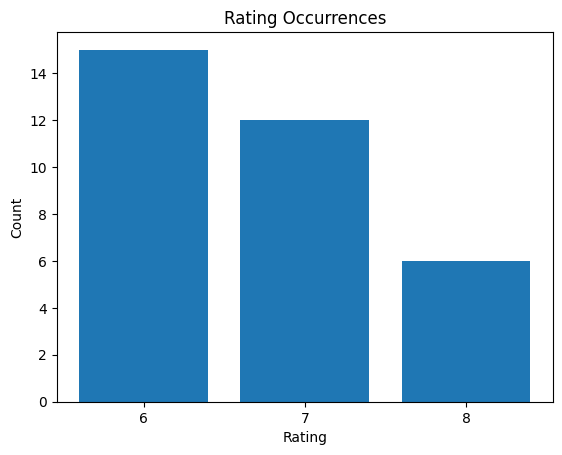

In [ ]:
avg_ratings = movies_dataframe["avg_rating"]
rating_counts = avg_ratings.value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.title("Movie Rating Occurrences")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rating_counts.index)
plt.show()


## *5. Reflection and Extension (1 point)*
*  The main challenge faced was the fact that the primary content were all stored in the `<script>` tag via json format. It wasn't explained in the practice jupyter notebook on how to handle this so I prompted ChatGPT help me: "*How to web-scrape one `<script type="application/ld+json">` using BeautifulSoup?*"
* If a website is more complex, i.e. the website is dynamic and has all main content loaded using javascript instead of static HTML, Selenium, as described in this [Geeks for Geeks tutorial](https://www.geeksforgeeks.org/python/scrape-content-from-dynamic-websites/), is a better tool to automatically handle ChromeDriver via webdriver-manager.
* An AI prompt to automate/improve my code could be: "*Given [my_code], what is one way that this webscraping and data processing code could be simplified? Or made to run more efficiently?*"